## Select seed

In [2]:
import sys
my_seed = 0 # int(sys.argv[1])

## Multiplicative factor on the number of users n to augment training data

In [3]:
attack = 'NK'
aug_factor_syn_profiles = 1 # nb of synthetic profiles to generate * n

## Filename to save results in npy format per method

In [4]:
filename_grr = 'results/adults/RSpFD_GRR_'

## Numba library for speeding up things

In [5]:
from numba import jit

## GRR functions

In [6]:
@jit(nopython=True)
def GRR(x, lst_val, p, q):
    """
    GRR mechanism
    input: true value x, domain values 'lst_val', and probabilities p,q
    output: true value w.p. 'p', random value (except x) w.p. 'q'
    """
    
    rnd = np.random.random()

    if rnd <=p:    
        return x
    else:
        return np.random.choice(lst_val[lst_val !=x]) 
    
@jit(nopython=True)
def GRR_Client(input_data, k, epsilon):
    """
    GRR mechanism

    :param input_data: user's true value;
    :param k: attribute's domain size;
    :param epsilon: privacy guarantee;
    :return: sanitized value.
    """
        
    # GRR parameters
    p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)

    # Mapping domain size k to the range [0, ..., k-1]
    domain = np.arange(k) 

    # GRR perturbation function
    rnd = np.random.random()
    if rnd <= p:
        return input_data

    else:
        return np.random.choice(domain[domain != input_data])

def RSpFD_GRR_Aggregator(reports_tuple, lst_k, d, amp_eps):

    if len(reports_tuple) == 0:

        raise ValueError('List of reports is empty.')

    reports_tuple = np.array(reports_tuple, dtype='object')

    # Number of reports
    n = len(reports_tuple)

    # Estimated frequency for all d attributes
    lst_freq_est = []
    for idx in range(d):
        reports = reports_tuple[:, idx]
        k = lst_k[idx]

        # GRR parameters with amplified epsilon
        p = np.exp(amp_eps) / (np.exp(amp_eps) + k - 1)
        q = (1 - p) / (k - 1)

        # Count how many times each value has been reported
        count_report = np.zeros(k)
        for rep in reports:
            count_report[rep] += 1

        # Ensure non-negativity of estimated frequency
        est_freq = np.array(((count_report * d * k) - n * (d - 1 + q * k)) / (n * k * (p - q))).clip(0)

        # Re-normalized estimated frequency
        norm_est_freq = est_freq / sum(est_freq)

        lst_freq_est.append(norm_est_freq)

    return np.array(lst_freq_est, dtype='object')    

## Main libraries

In [7]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd; pd.set_option('mode.chained_assignment',None)
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import copy
import time
import csv
from pandas.core.common import flatten
import ray

#ML
from xgboost import XGBClassifier

## Reading dataset

In [8]:
df = pd.read_csv('db_Adult.csv')
# df = df.sample(frac=0.1)
# df.reset_index(inplace=True, drop=True)
df.reset_index(inplace=True)
df.rename(columns={'index': 'ID', 'marital-status': 'marital_status', 'native-country': 'native_country'}, inplace=True)
df

,ID,age,workclass,education,marital_status,occupation,relationship,race,sex,native_country,salary
0,0,50,Self-emp-not-inc,Assoc-voc,Married-civ-spouse,Sales,Husband,White,Male,United-States,>50K
1,1,28,Private,HS-grad,Never-married,Transport-moving,Not-in-family,Other,Male,United-States,<=50K
2,2,45,Private,HS-grad,Married-civ-spouse,Sales,Husband,White,Male,United-States,>50K
3,3,18,Private,10th,Never-married,Other-service,Own-child,White,Male,United-States,<=50K
4,4,33,Private,Bachelors,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...
4517,4517,60,Private,Some-college,Divorced,Adm-clerical,Not-in-family,White,Female,United-States,<=50K
4518,4518,30,Private,Prof-school,Never-married,Prof-specialty,Not-in-family,White,Male,United-States,>50K
4519,4519,48,Self-emp-inc,Bachelors,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States,>50K
4520,4520,48,Private,9th,Widowed,Transport-moving,Unmarried,White,Male,United-States,>50K


## Dataset to work with

In [9]:
attributes = list(df.drop('ID', axis=1).columns)

LE = LabelEncoder()

for col in attributes:
    df[col] = LE.fit_transform(df[col])
df

,ID,age,workclass,education,marital_status,occupation,relationship,race,sex,native_country,salary
0,0,33,4,8,2,11,0,4,1,36,1
1,1,11,2,11,4,13,1,3,1,36,0
2,2,28,2,11,2,11,0,4,1,36,1
3,3,1,2,0,4,7,3,4,1,36,0
4,4,16,2,9,2,0,0,4,1,36,1
...,...,...,...,...,...,...,...,...,...,...,...
4517,4517,43,2,15,0,0,1,4,0,36,0
4518,4518,13,2,14,4,9,1,4,1,36,1
4519,4519,31,3,9,2,3,5,4,0,36,1
4520,4520,31,2,6,6,13,4,4,1,36,1


## Re-identification Attack Function

In [10]:
@ray.remote
def attack_re_identification(lst_idx, dic_id, df):
    """
    
    input:
    output:
    """
        
    lst_topk = []
    
    for usr_id in lst_idx:

        df_atk_dist = df.append(pd.DataFrame.from_dict(dic_id[usr_id], orient='index').transpose(), ignore_index=True).fillna(-1).astype(int)
        similarity = np.where(df_atk_dist.iloc[-1] == df_atk_dist[:-1], True, False).sum(axis=1)

        df_atk_dist = df_atk_dist.drop(df_atk_dist.shape[0]-1)
        df_atk_dist['Similarity'] = similarity
        df_atk_dist = df_atk_dist.sort_values('Similarity', ascending=False)
        simi = 1
        lst_ids = list(df_atk_dist.loc[df_atk_dist['Similarity'] >= df_atk_dist['Similarity'].max()].sample(frac=1).index)
        for simi in range(1, 5): 
            if len(lst_ids) >=10:
                pass
            else: 
                lst_ids+= list(df_atk_dist.loc[df_atk_dist['Similarity'] == df_atk_dist['Similarity'].max()-simi].sample(frac=1).index)

        #save the minimum top-k the user was re-identified
        try: 
            lst_topk.append(np.where(usr_id == np.array(lst_ids)[:10])[0][0] + 1)
        except: pass
                
    return lst_topk

## Static parameters

In [11]:
#number of users (n)
n = df.shape[0]
print('Number of Users =',n)

#number of dimensions (d)
d = len(attributes)
print('Number of Attributes =', d)

#sampling rate
beta = 1/d
print('beta =', beta)

#domain size of attributse
lst_k = [len(df[att].unique()) for att in attributes]
print('Domain size of attributes =', lst_k)

#number of surveys (nb_surveys)
nb_surveys = 5
print('Number of Surveys =', nb_surveys)

#min number of attributes per survey
min_att_per_survey = np.rint(d/2).astype(int)
print('Min number of attributes per survey =', min_att_per_survey)

#range of epsilon
lst_eps = list(range(1, 11))
print('Epsilon values =', lst_eps)

Number of Users = 4522
Number of Attributes = 10
beta = 0.1
Domain size of attributes = [69, 7, 16, 7, 14, 6, 5, 2, 39, 2]
Number of Surveys = 5
Min number of attributes per survey = 5
Epsilon values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## Reidentification RS+FD[GRR]: No Knowledge, Surveys with Different Attributes, Uniform $\epsilon$

In [12]:
starttime = time.time()

dic_rsfd_grr = {} # initialize dictionary to save df result per epsilon

print(my_seed)

nb_cores = 12

np.random.seed(my_seed)

# initialize dictionary to save number of people re-identified per epsilon
re_ident_attack = {} 

# divide the dataset in nb_cores equal parts for later parallelization with Ray library
lst_idx_per_core = [list(_) for _ in np.array_split(df.index, nb_cores)]

# Randomly choose the number of attributes for each survey between min_att_per_survey and d
nb_att_survey = np.random.randint(min_att_per_survey, d, nb_surveys)

# Randomly select the indexes of the attributes for each survey
lst_att_survey = [np.random.choice(range(d), nb, replace=False) for nb in nb_att_survey]

for epsilon_tot in lst_eps: #iterate over each epsilon value
    
    #Initializing a dictionary for each users' profile
    dic_re_id = {ID:{att:[] for att in attributes} for ID in range(n)}
    
    #Dictionary to save number of re-identified profiles per top-k group
    atk_top_k = {survey:{top_k:0 for top_k in range(1, 11)} for survey in range(1, nb_surveys + 1)}

    #For each survey
    for survey in range(1, nb_surveys + 1):  
        
        eps_l = np.log(nb_att_survey[survey-1] * (np.exp(epsilon_tot) - 1) + 1) #amplification by sampling
        
        #nprofiles with rs+FD
        dic_id = {key:[] for key in range(n)}
        
        # we'll shuffle the users' order in the dataset
        df_shfl = df.sample(frac=1, random_state=my_seed+survey) #change seed with survey
        df_shfl.reset_index(drop=True, inplace=True)
        
        lst_reports = []
        lst_label = []
        for ind, row in df_shfl.iterrows():
            
            # Select an attribute at random
            while True:
                rnd_att = np.random.choice(lst_att_survey[survey - 1])
                if dic_re_id[row['ID']] != rnd_att:
                    break
            lst_label.append(rnd_att)
            
            # RS+FD perturbation function
            sanitized_ue_tuple = []
            for idx in lst_att_survey[survey - 1]:

                # Fake data generation (with UE applied to a zero vector)
                if idx != rnd_att:
                    ze_val = np.random.randint(lst_k[idx])
                    dic_id[row['ID']].append(ze_val)
                    sanitized_ue_tuple.append(ze_val)

                # Local randomization
                else:
                    ran_val = GRR_Client(row[attributes[idx]], lst_k[idx], eps_l)
                    dic_id[row['ID']].append(ran_val)
                    sanitized_ue_tuple.append(ran_val)
            
            lst_reports.append(sanitized_ue_tuple)
        
        rs_fd = RSpFD_GRR_Aggregator(lst_reports, [lst_k[val] for val in lst_att_survey[survey - 1]], nb_att_survey[survey - 1], eps_l)
        est_rs_fd = {}
        for index_att in range(nb_att_survey[survey - 1]):
            est_rs_fd[lst_att_survey[survey - 1][index_att]] = rs_fd[index_att]
            
        # Attacking part
        dic_id_syn = {}
        for _ in range(aug_factor_syn_profiles*n):

            profile = np.zeros(nb_att_survey[survey - 1]+1)
            smp_att = np.random.choice(lst_att_survey[survey - 1])
            
            idx=0
            for index_att in lst_att_survey[survey - 1]:
                att = attributes[index_att]
                k = lst_k[index_att]

                lst_val = np.arange(k) # take domain values of the attribute
                if index_att != smp_att:
                    profile[idx] = np.random.randint(k)
                else:
                    # GRR parameters with amplified epsilon (eps_l)
                    p = np.exp(eps_l) / (np.exp(eps_l) + k - 1) 
                    q = (1 - p) / (k - 1)

                    #following estimated distributions
                    profile[idx] = GRR(np.random.choice(lst_val, p=est_rs_fd[index_att]), lst_val, p, q)
                idx+=1
            profile[-1] = smp_att
            dic_id_syn[_] = profile.astype(int)

        df_train = pd.DataFrame.from_dict(dic_id_syn, orient='index')
        df_train.columns = [str(val) for val in lst_att_survey[survey - 1]] + ['Smp_Att']
        df_train = df_train.sample(frac=1)
        df_train.reset_index(drop=True, inplace=True)

        x_train = df_train.drop('Smp_Att', axis = 1)
        y_train = df_train['Smp_Att']

        df_test = pd.DataFrame.from_dict(dic_id.values())
        df_test.columns = [str(val) for val in lst_att_survey[survey - 1]] 
        df_test['Smp_Att'] = lst_label
        df_test.reset_index(drop=True, inplace=True)

        x_test = df_test.drop('Smp_Att', axis = 1)
        y_test = df_test['Smp_Att']

        model = XGBClassifier(random_state=my_seed, n_jobs=-1, eval_metric='mlogloss')
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)

        for _ in range(n):
            
            if len(dic_re_id[_][attributes[y_pred[_]]])==0:
                dic_re_id[_][attributes[y_pred[_]]].append(df_test.loc[_, str(y_pred[_])])              
        
        #start attacking after 2 surveys
        if survey >= 2:

            result_parallel = [] #initialize list for parallelized results
            for lst_idx in lst_idx_per_core: 

                result_parallel.append(attack_re_identification.remote(lst_idx, dic_re_id, df)) #use remote function from Ray library

            parallel_atk = list(flatten(ray.get(result_parallel))) #take results with get function from Ray library

            lst_top_k = np.zeros(11) #initialize list of top-k re-identification attack

            for idx in range(len(parallel_atk)): #for each attacked profile

                for top_k in range(parallel_atk[idx], 11): #count as attack the top-k's group
                    lst_top_k[top_k] += 1

            atk_top_k[survey] = lst_top_k #store attack result for this number of surveys

    #for each epsilon we save the number of re-identified profiles for all top-k
    re_ident_attack[epsilon_tot] = atk_top_k

# Saving to local file
np.save(filename_grr+'Smp_Re_Ident_Attack_LDP_FK_Uniform_Seed_'+str(my_seed)+'.npy', re_ident_attack) 

print('That took {} seconds'.format(time.time() - starttime))    

0
That took 452.3131527900696 seconds


## Results

In [13]:
## Some libraries
import matplotlib.pyplot as plt
import matplotlib
params = {'axes.titlesize':'18',
          'xtick.labelsize':'16',
          'ytick.labelsize':'16',
          'font.size':'18',
          'legend.fontsize':'medium',
          'lines.linewidth':'2',
          'font.weight':'normal',
          'lines.markersize':'12'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Parameters

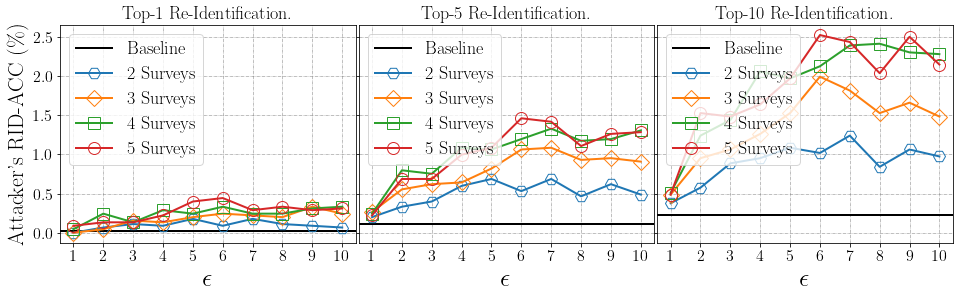

In [14]:
nb_seed = 1

fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
plt.subplots_adjust(wspace=0.01)

r = 0 #row

markers = ['H', 'D', 's', 'o'] 
lines = ['dashed', 'dotted', 'dashdot', (0, (1, 10))]

for top_k in [1, 5, 10]:
    ax[r].grid(color='grey', linestyle='dashdot', linewidth=0.5)
    ax[r].axhline(y= 100 * top_k/n, color='black', label='Baseline') #our baseline is a random top-k group
    
    #averaging results over nb_seed times
    for survey in range(2, nb_surveys + 1):
        
        lst_resul_atk = []
        for seed in range(nb_seed):
            lst_resul_atk.append(np.load(filename_grr+'Smp_Re_Ident_Attack_LDP_FK_Uniform_Seed_'+str(seed)+'.npy', allow_pickle=True).reshape(-1))
        
        error_rate_atk = 100 * np.array([np.mean([lst_resul_atk[idx][0][eps_l][survey][top_k] for idx in range(len(lst_resul_atk))]).astype(int) for eps_l in lst_eps])/n
        
        ax[r].plot(range(len(lst_eps)), error_rate_atk, label=str(survey)+' Surveys', marker=markers[survey-2], markerfacecolor='none')

    ax[r].set_title('Top-'+ str(top_k)+ ' Re-Identification.')
    ax[r].set_xlabel('$\epsilon$', fontsize=26)
    ax[0].set_ylabel("Attacker's RID-ACC (\%)", fontsize=22)
    ax[r].set_xticks(range(len(lst_eps)))
    ax[r].set_xticklabels(lst_eps)
    ax[r].legend(loc='upper left')
    
    r += 1 
    
# plt.savefig(, dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

Please execute with more seeds for more stable plots